<a href="https://colab.research.google.com/github/Vivek-afk81/data_mining/blob/main/TimeSeries_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/data_mining")
print(os.getcwd())

/content/drive/My Drive/data_mining


##Import libraries

In [10]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 16.0 MB/s eta 0:00:00


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima
from scipy import stats

##Load and Prepare the data

In [4]:
df=pd.read_csv("/content/drive/My Drive/data_mining/data/AirPassengers.csv",parse_dates=['Month'],index_col=['Month'])
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


#Time-Series Decomposition

First we plot the data

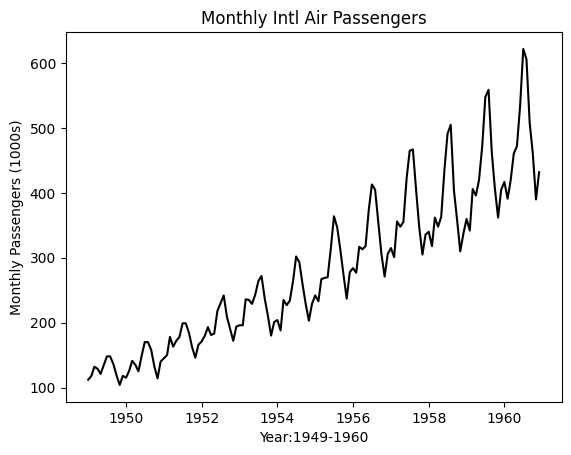

In [6]:
fig,ax=plt.subplots()
plt.xlabel('Year:1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(df,color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

DECOMPOSE TIME SERIES

* Decompose the time series into three components: trend, seasonal, and residuals or noise.
* This commands also plots the components.
* The argument period specifies that there are 12 observations (i.e., months) in the cycle.
* By default, seasonal_decompose performs an additive (as opposed to multiplicative) decomposition.

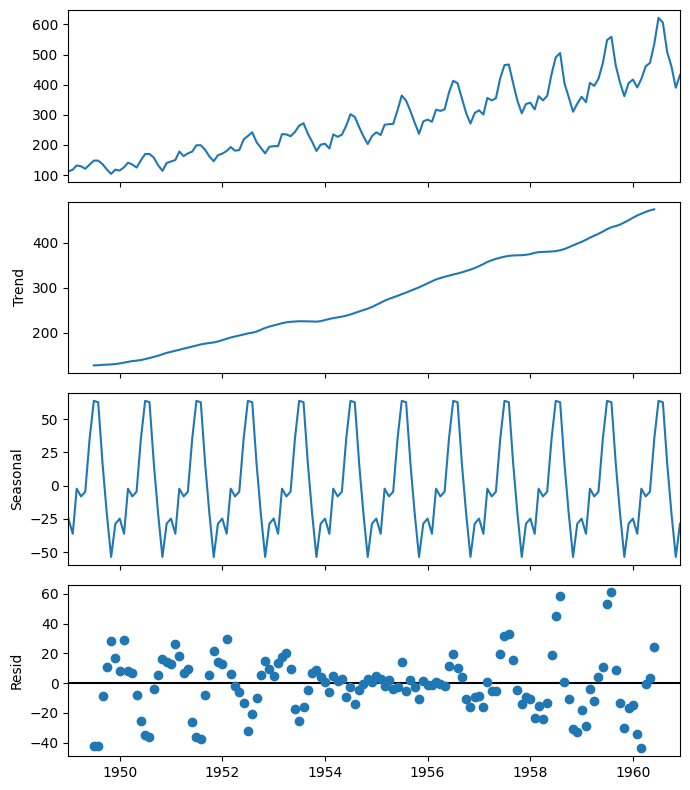

In [7]:
# Set the figure size
plt.rcParams['figure.figsize']=[7,8]

# Plot the decomposition components
sd=seasonal_decompose(df,period=12).plot()

* For growth over time, it may be more appropriate to use a multiplicative trend.
* The approach can show consistent changes by percentage.
* In this approach, the residuals should be centered on 1 instead of 0.

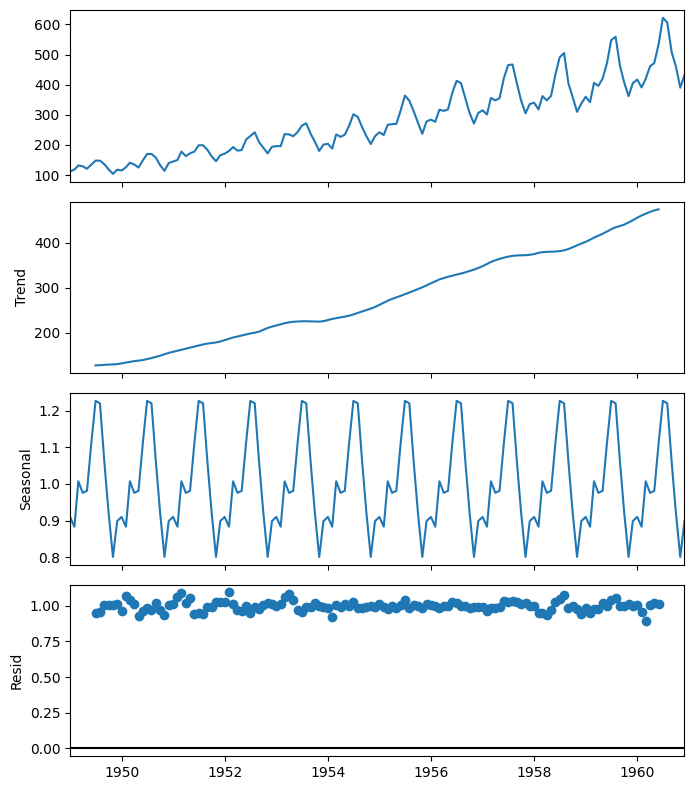

In [8]:
sd=seasonal_decompose(df,model='multiplicative').plot()

#ARIMA: Autoregressive Integrated Moving Average

###Plot the data


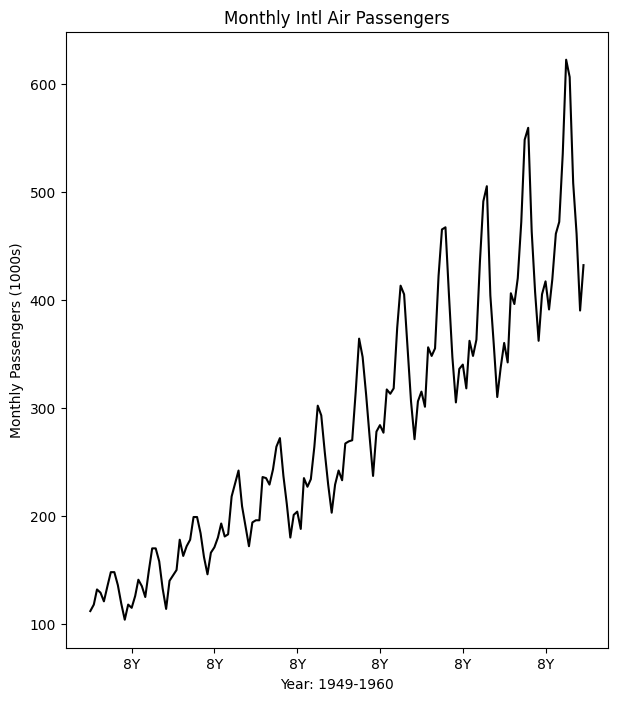

In [12]:
fig, ax = plt.subplots ()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(df, color='black' )
ax.xaxis.set_major_formatter (DateFormatter('8Y'))

###Split Data


*   Our goal is to predict future values in the time series

*   To do this, we'll use data from 1949 thorough 1957 for the training model
*   We'll then use the data from 1958 through 1960 for testing the predictions





###Create Training Dataset

* Select the data before 1958

In [13]:
trn=df.loc[df.index<'1958-01-01']

plot the training data

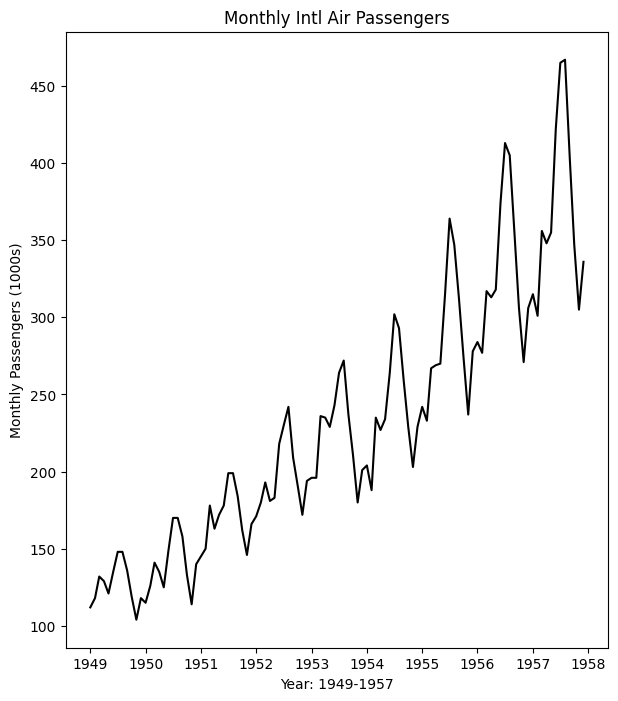

In [15]:
fig,ax=plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(trn,color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

###Creating a Testing Dataset

use the dataset from 1958 through 1960(the last three years) for testing

In [16]:
tst=df.loc[df.index>='1958-01-01']

Plot the testing data

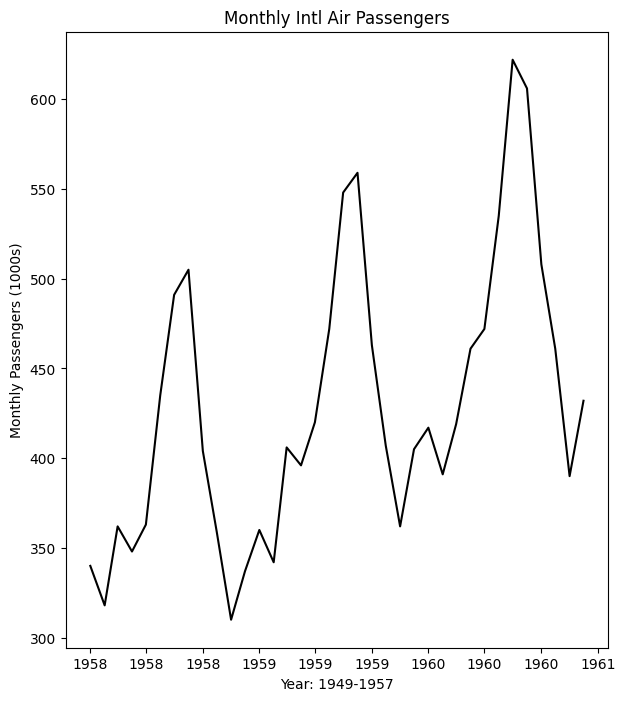

In [17]:
fig,ax=plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(tst,color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

###PREPARE MODEL

####Test Stationarity

ARIMA requires non-stationary data. That is, ARIMA needs data where the mean, the variance, and/or the covariance vary over time. Non-stationary data
shows significant correlations when lagged. A "correlogram" graph (or ACF plot) shows the degree of correlation at different values of lag. Ideally, none of the
lag values will fall in the range of nonsignificant correlations.

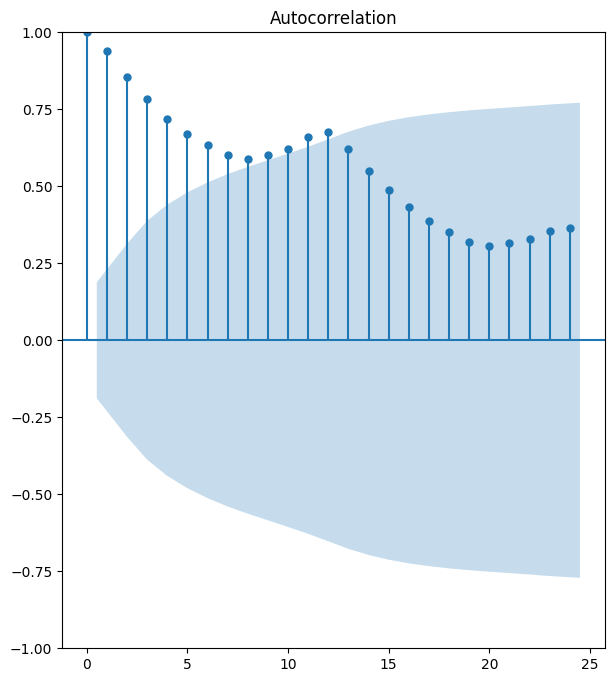

In [27]:
trn_acf=plot_acf(trn, lags=24)

###Linear Model

* Fit a linear regression model to serve as a baseline
* The dependent(or endogeneous) variable is the number of passengers

* The independent(or exogeneous) variable is a linear time in trend, including a constant(or intercept)


In [28]:
lr=sm.OLS(endog=trn['#Passengers'],exog=sm.add_constant(np.arange(1,1+trn.shape[0]))).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:            #Passengers   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     526.7
Date:                Sun, 18 Jan 2026   Prob (F-statistic):           6.40e-43
Time:                        05:08:42   Log-Likelihood:                -536.80
No. Observations:                 108   AIC:                             1078.
Df Residuals:                     106   BIC:                             1083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.0422      6.820     13.936      0.0

Extract the fitted values

In [29]:
y_hat=lr.fittedvalues

In [30]:
y_ci=lr.get_prediction().conf_int(alpha=.05)

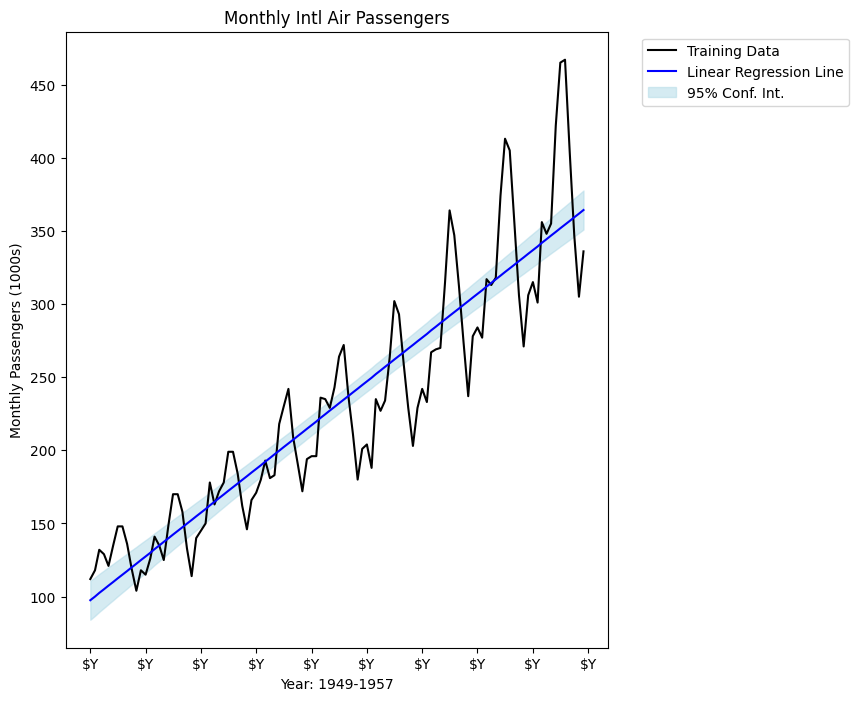

In [31]:
fig, ax = plt.subplots ( )
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(trn, color='black', label='Training Data')
plt.plot(y_hat, color='blue', label='Linear Regression Line' )
plt.fill_between(y_hat.index, y_ci[:, 0], y_ci[:, 1], color='lightblue', alpha=0.5, label='95% Conf. Int.')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('$Y') )

###ARIMA: TRAIN MODEL

Find the best ARIMA order using the auto_arima function in the pmdarima package. Note that the auto_arima function assumes that the time series
is non-seasonal by default (i.e. the seasonal period "m" is set equal to 1 by default). In what follows we set "m" equal to 12 to ensure that the selected optimal
model takes into account the annual seasonality observed in the time series (one cycle every 12 months).

Note: We are actually conducting a variation on ARIMA called "SARIMAX," or "Seasonal Auto-Regressive Integrated Moving Average with Exogenous
Factors."


In [32]:
auto_arima_model = auto_arima(trn, m=12, with_intercept=False, suppress_warnings=True)
print(auto_arima_model.summary( ))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Sun, 18 Jan 2026   AIC                            704.001
Time:                                    05:14:51   BIC                            709.109
Sample:                                01-01-1949   HQIC                           706.065
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439   

The `auto_arima` function suggests **ARIMA(1,1,0)(0,1,0,12)**.

The first set of numbers corresponds to the basic (non-seasonal) model:

- **p = 1** — Auto-regressive (AR) order  
- **d = 1** — Degree of differencing  
- **q = 0** — Moving average (MA) order



In [33]:
auto_arima_model.order

(1, 1, 0)



The second set of numbers corresponds to the **seasonal component**:

- **P = 0** — Seasonal auto-regressive (AR) order  
- **D = 1** — Seasonal degree of differencing  
- **Q = 0** — Seasonal moving average (MA) order  
- **M = 12** — Seasonal period (e.g., 12 for monthly data with yearly seasonality)


In [34]:
auto_arima_model.seasonal_order

(0, 1, 0, 12)

Extract the residuals

In [35]:
resid=auto_arima_model.resid()

plot the standardized residuals

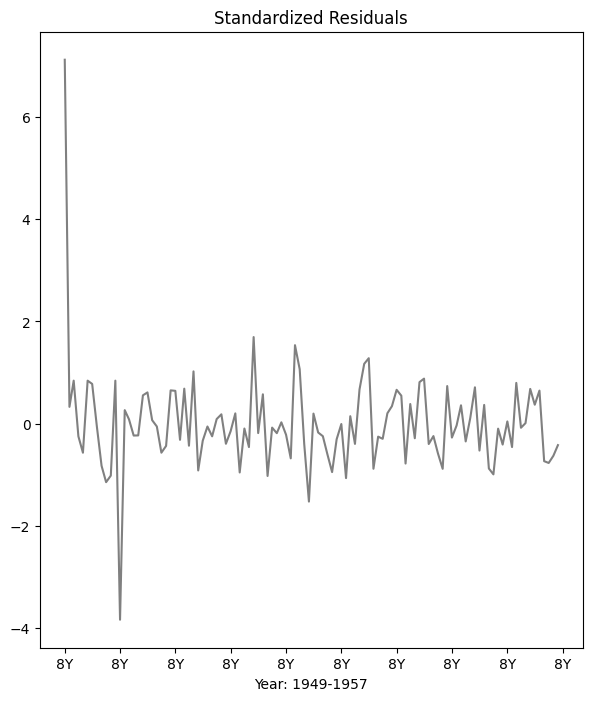

In [39]:
fig, ax = plt.subplots ()
plt.plot(trn.index, stats.zscore(resid), color='gray' )
plt.title('Standardized Residuals')
plt.xlabel('Year: 1949-1957')
ax.xaxis.set_major_formatter (DateFormatter('8Y') )

plot the ACF of residuals

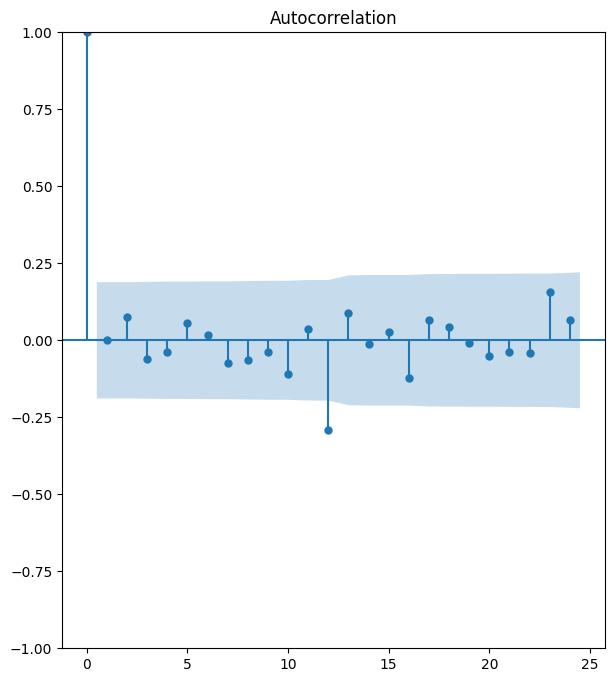

In [37]:
res_acf=plot_acf(resid,lags=24)

plot the p-values of the Ljung-Box test for auto correlation

In [43]:
res_lb = acorr_ljungbox(resid, lags=24, return_df=True)['lb_pvalue']

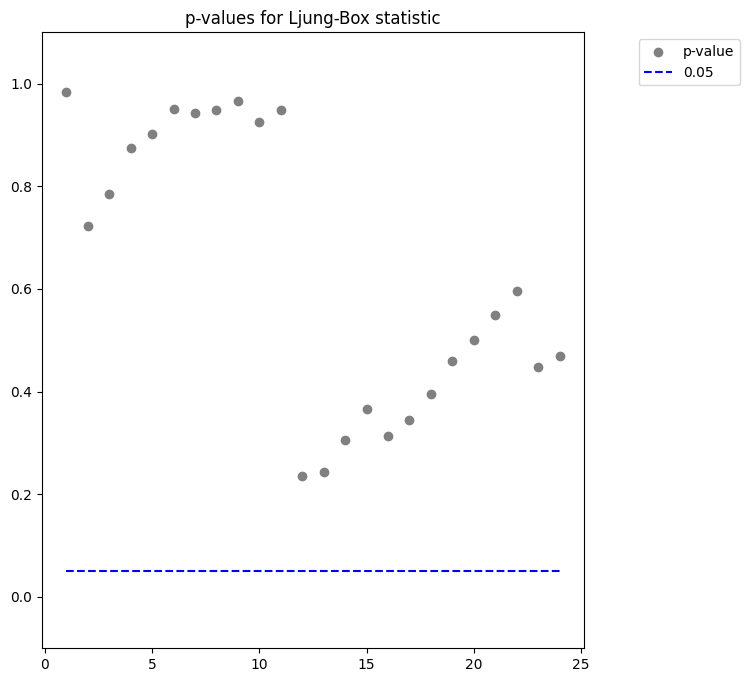

In [45]:
fig, ax = plt.subplots ()
plt.title('p-values for Ljung-Box statistic' )
plt.scatter(np.arange(1, 1 + len(res_lb) ), res_lb, color='gray', label='p-value' )
plt.plot(np.arange(1, 1 + len(res_lb)), [0.05] * len(res_lb), '--', color='blue', label='0.05')
plt.ylim(-0.1, 1.1)
plt.legend(bbox_to_anchor=(1.3, 1))

###Test the model

In [46]:
auto_arima_model.fit(trn)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [48]:
arima_predictions= auto_arima_model.predict(n_periods=36,alpha=.05,return_conf_int=True)

Extract the timeseries of model predictions

In [49]:
y_pred=pd.Series(arima_predictions[0],index=tst.index)

Extract the 95% prediction interval

In [52]:
y_pred_lb,y_pred_ub=arima_predictions[1][:,0],arima_predictions[1][:,1]

* Graph the training data (1949-1957).
* Add the predictions for the testing data (1958-1960).
* Add observed values from testing data.

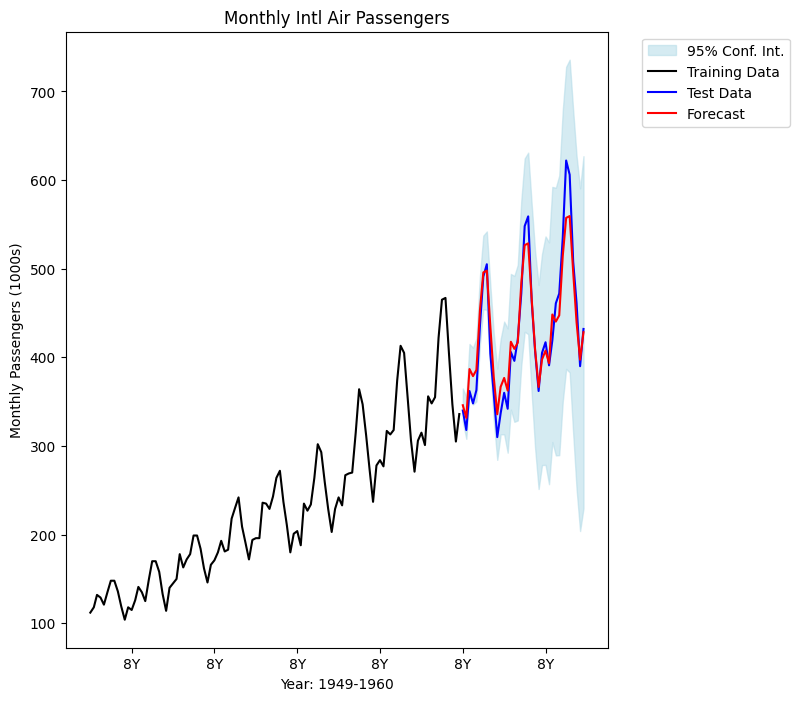

In [53]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.fill_between(tst.index, y_pred_lb, y_pred_ub, color='lightblue', alpha=0.5, label='95% Conf. Int.')
plt.plot(trn, color='black', label='Training Data' )
plt.plot(tst, color='blue', label='Test Data' )
plt.plot(y_pred, color='red', label='Forecast')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter (DateFormatter ('8Y') )

* Create a dataframe with the observed values for the testing dataset.
* Add the predictions from the ARIMA model.
* Add the low and high boundaries for the 95% confidence intervals.

In [55]:
tst_pred = pd.DataFrame ({
    'Actual': tst.iloc[:, 0].values,
    'Point Forecast': y_pred. values,
    'Lo 95': y_pred_lb,
    'Hi 95': y_pred_ub
    }, index=tst.index)

In [56]:
tst_pred.head()

,Actual,Point Forecast,Lo 95,Hi 95
Month,,,,
1958-01-01,340,345.964471,327.088699,364.840243
1958-02-01,318,331.731920,308.036230,355.427610
1958-03-01,362,386.787992,358.515740,415.060244
1958-04-01,348,378.774472,346.695454,410.853490
1958-05-01,363,385.777732,350.270764,421.284700
